In [1]:
!conda install -y gdown

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.7.1             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    openssl-1.1.1p             |       h166bdaf_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.7.1-pyhd8ed1ab_0
  gdown              conda-forge/noarch::gdown-4.4.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  openssl                                 1.1.1o-h166bdaf_0 --> 1.1.1p-h166bdaf_0



gdown-4.4.0          | 16 KB     | #########################

download clean dataset

In [2]:
!gdown --id 1FVn-onNGHAxs_Xw8Nh0mkvxCQdak0Hgj

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1FVn-onNGHAxs_Xw8Nh0mkvxCQdak0Hgj
To: /kaggle/working/train.csv
100%|██████████████████████████████████████| 18.9M/18.9M [00:00<00:00, 70.0MB/s]


In [3]:
!gdown --id 1-0RazmVNm7eB707h9otYoaJk8zOHrNca

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-0RazmVNm7eB707h9otYoaJk8zOHrNca
To: /kaggle/working/dev.csv
100%|███████████████████████████████████████| 2.11M/2.11M [00:00<00:00, 179MB/s]


# install packages

In [4]:
!pip install parsivar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 37.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for parsivar: filename=parsivar-0.2.3-py3-none-any.whl size=36492972 sha256=2a29a06298bba89d4cf64796cb4b4099e4ef7fb086b8270c9c2f50ec331902bd
  Stored in directory: /root/.cache/pip/wheels/ae/67/7a/49cbf08f64d3f76a26eceaf0e481a40e233f05d4356875cbed
  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449922 sha256=8008f8b7990720ea22f0107bc3b4f1d5fa393063ed09fff51e86c82de831afb3
  Stored in directory: /root/.cache/pip/wheels/48/8b/7f/473521e0c731c6566d631b281f323842bbda9bd819eb9a3ead
Successfully built parsivar nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently 

In [5]:
!pip install hazm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.2 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394486 sha256=ba599b8149e22d25888707a89872d346df6712cb742ddad4adac8e3285f954f0
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=192769 sha256=95d7602d7f436df704a9de7070efc7d3f23a89ab30c4eb5295b5200cc75b8194
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.4.5
    Uninstalling nltk-3.4.5:

In [6]:
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17416 sha256=62d1487249d326d40f23cc0a1df1e3a185ebfce98a6b54cf717abe2d8373f2ba
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.13.0
    Uninstalling

In [7]:
!pip install finglish

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.7 MB/s eta 0:00:0000:0100:01


In [8]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=0d95b2d5b0f9bbf4e0d3a857677f80a22d0626e380b731de87552a9ca68ea2b6
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [13]:
# !pip install -U textblob
# !python -m textblob.download_corpora

In [9]:
!pip install transformers

# imports

In [10]:
from googletrans import Translator
import parsivar
from finglish import f2p
import hazm
import requests
import io
from textblob import Word
import os
from langdetect import detect

Loading converters...
Loading persian word list...
Loading dictionary...


In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras import Model
import keras

In [86]:
from transformers import BertTokenizer, TFBertModel
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel

In [14]:
tf.__version__, keras.__version__

('2.6.4', '2.6.0')

# utility

In [15]:
def get_stopwords():
  url = "https://raw.githubusercontent.com/zolfaShefreie/Sentiment-Analysis-of-SnappFood-Comments/main/persian_stopword"
  content = requests.get(url).content.decode("utf-8") 
  return set([w for w in content.split('\n') if w])


In [16]:
class TextCleaner:
    punc = '''!()-[]{.};:'"\,<>/?@#$%^&*_~`|’“”…—–'''
    normalizer = parsivar.Normalizer(date_normalizing_needed=True, 
                                     statistical_space_correction=True)
    stemmer = parsivar.FindStems()
    lemmatizer = hazm.Lemmatizer()
    tokenizer = parsivar.Tokenizer()
    translator = Translator()
    stopwords = get_stopwords()

    @classmethod
    def normalize(cls, text):
        """
        convert to persian and normlize the text
        """
        if detect(text) == "en":
            text = cls.translator.translate(text, src="en", dest="fa").text
        elif detect(text) != "fa":
            text = f2p(text)
        text = cls.normalizer.normalize(text)
        return text
    
    @classmethod
    def remove_punc(cls, text):
        for each in cls.punc:
            text = text.replace(each, ' ')
        return text
    
    @classmethod
    def stem_lemmet_word(cls, word):
        """
        apply stem and lemmet on word
        """
        new_word = word.strip()
        new_word = cls.stemmer.convert_to_stem(new_word)
        if '&' in new_word:
            new_word = new_word.split('&')[0]
        new_word = cls.lemmatizer.lemmatize(new_word)
        if '#' in new_word:
            new_word = new_word.split('#')[0]
        return new_word
        

    @classmethod
    def word_cleaning(cls, text, use_stemm=True, use_lemmet=True, 
                      remove_stopword=True):
      tokens = cls.tokenizer.tokenize_words(text)
      new_text = str()
      for token in tokens:
          if use_stemm:
              token = cls.stemmer.convert_to_stem(token)
              if '&' in token:
                  token = token.split('&')[0]
          if use_lemmet:
              token = cls.lemmatizer.lemmatize(token)
              if '#' in token:
                  token = token.split('#')[0]
          if remove_stopword and token in cls.stopwords:
              continue
          new_text += " " + token
      return new_text
    
    @classmethod
    def clean_text(cls, text, use_stemm=False, use_lemmet=False, 
                   remove_stopword=False):

        text = cls.normalize(text)
        text = cls.remove_punc(text)
        text = cls.word_cleaning(text, use_stemm, use_lemmet, remove_stopword)
        text = text.replace('‌', ' ')
        text = " ".join(text.split())
        return text


In [17]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [18]:
def get_embedding_matrix(word_index, embedding_index, embed_dim, check_word_clean=True):
    """
    create matrix besed on word_index
    """
    embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
    miss_word = set()
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word, None)
        if embedding_vector is None:
            embedding_vector = embedding_index.get(TextCleaner.stem_lemmet_word(word), None)
        if embedding_vector is not None:
            try:
                embedding_matrix[i] = np.fromiter(embedding_vector, dtype='float32')
            except:
                pass
        else:
            miss_word.add(word)
    return embedding_matrix, miss_word

# load dataset

In [18]:
train_file_path = "./train.csv"
validation_file_path = "./dev.csv"
need_clean_train = False
need_cleean_validation = False

In [19]:
train_df = pd.read_csv(train_file_path, delimiter='\t' if need_clean_train else None , index_col=0)
validation_df = pd.read_csv(validation_file_path, delimiter='\t' if need_clean_train else None, index_col=0)

In [20]:
train_df

,comment,label,label_id,clean_comment
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0,قرار بود 1 ساعته برسه ولی نیم ساعت زودتر از مو...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1,قیمت این مدل اصلا با کیفیتش سازگاری نداره ، فق...
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0,شیرینی وانیلی فقط 1 مدل بود
...,...,...,...,...
56695,یک تیکه کم فرستاده بودن و با تماس من در کمترین...,HAPPY,0,1 تیکه کم فرستاده بودن و با تماس من در کمترین ...
56696,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...,HAPPY,0,عالی بود همه چیز ممنونم پیک هم خیلی مرتب و به ...
56697,مثل همیشه عالی، من چندمین باره سفارش میدم و هر...,HAPPY,0,مثل همیشه عالی ، من چندمین باره سفارش میدم و ه...
56698,دلستر استوایی خواسته بودم اما لیمویی فرستادند,HAPPY,0,دلستر استوایی خواسته بودم اما لیمویی فرستادند


In [21]:
validation_df

,comment,label,label_id,clean_comment
0,همه ساندویچ‌ها سرد بود متاسفانه در صورتی که فا...,SAD,1,همه ساندویچ ها سرد بود متاسفانه در صورتی که فا...
1,تشکر، عالی‌تر از همیشه,HAPPY,0,تشکر ، عالی تر از همیشه
2,مرغ و کدو رو دوس نداشتم ولی کلا ساندویچهای خوش...,HAPPY,0,مرغ و کدو رو دوس نداشتم ولی کلا ساندویچهای خوش...
3,نمیدونم هزینه بسته بندی به چه دلیل گرفته شد؟؟؟,SAD,1,نمیدونم هزینه بسته بندی به چه دلیل گرفته شد ؟؟؟
4,یک نوشابه کم ارسال شد و تاخیر فراوان و غذای نس...,SAD,1,1 نوشابه کم ارسال شد و تاخیر فراوان و غذای نسب...
...,...,...,...,...
6295,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...,SAD,1,سلام من به فاکتور غذاهایی که سفارش میدم احتیاج...
6296,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...,SAD,1,سایز پیتزا نسبت به سفارشاتی که قبلا گذشتم کم ش...
6297,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...,HAPPY,0,من قارچ اضافه رو اضافه کرده بودم بودم اما اگر ...
6298,همرو بعد ۲ساعت تاخیر اشتباه آوردن پولشم رفت رو...,SAD,1,همرو بعد 2ساعت تاخیر اشتباه آوردن پولشم رفت رو...


# Model Using mBert and XLM-Roberta 

In [22]:
def tokenize(sentences, tokenizer, max_len=128):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=max_len, padding='max_length', 
                                             return_attention_mask=True, return_token_type_ids=True, truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

## using mBert

In [23]:
max_len = 128

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [25]:
train_ids, train_mask, train_segments = tokenize(train_df.clean_comment, tokenizer, max_len)
val_ids, val_mask, val_segment = tokenize(validation_df.clean_comment, tokenizer, max_len)

In [26]:
train_ids.shape, val_ids.shape

((56700, 128), (6300, 128))

In [27]:
save_model_path = "./mbert_model.h5"

In [63]:
os.remove(save_model_path)

In [65]:
def get_mbert_model(max_len, save_model_path):
    """
    load model if exists else create a model and return compiled model
    """
    mbert_model = TFBertModel.from_pretrained("bert-base-multilingual-uncased")
    if os.path.exists(save_model_path):
        model = tf.keras.models.load_model(save_model_path, custom_objects={'TFBertModel': TFBertModel})
        return model, False
    
    else:
        input_ids = Input(shape=(max_len,), name='input_token', dtype='int32')
        input_mask_ids = Input(shape=(max_len,), name='input_token_mask', dtype='int32')
        x = mbert_model(input_ids, input_mask_ids)[0][:,0,:]
        x = Dropout(0.5)(x)
        preds = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=[input_ids, input_mask_ids], outputs=preds)
        model.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      metrics=['accuracy'])
        return model, True

In [66]:
model, need_train = get_mbert_model(max_len, save_model_path)

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [67]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_token_mask (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_9 (TFBertModel)   TFBaseModelOutputWit 167356416   input_token[0][0]                
                                                                 input_token_mask[0][0]           
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 768)          0           tf_bert_model_9[0][0]      

### train model

In [68]:
if need_train:
    history = model.fit([train_ids, train_mask], train_df.label_id, 
              validation_data=([val_ids, val_mask], validation_df.label_id),
              epochs=10, 
              batch_size=64,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min')])
    model.save(save_model_path)

Epoch 1/10
886/886 [==============================] - 842s 934ms/step - loss: 0.3759 - accuracy: 0.8333 - val_loss: 0.3300 - val_accuracy: 0.8602
Epoch 2/10
886/886 [==============================] - 825s 931ms/step - loss: 0.3098 - accuracy: 0.8698 - val_loss: 0.3138 - val_accuracy: 0.8663
Epoch 3/10
886/886 [==============================] - 825s 931ms/step - loss: 0.2860 - accuracy: 0.8805 - val_loss: 0.3148 - val_accuracy: 0.8692


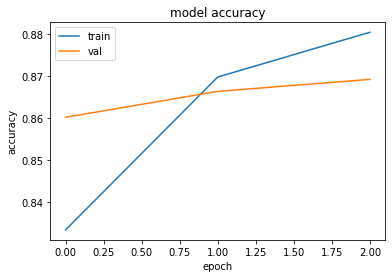

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

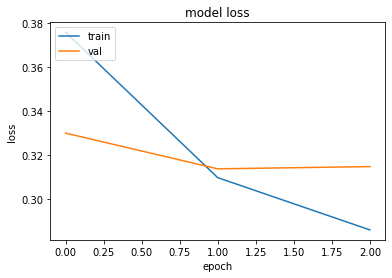

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### evaluate

In [75]:
test_path = "./dev.csv"
raw_version = False

In [77]:
test_df = pd.read_csv(test_path, delimiter='\t' if raw_version else None  , index_col=0)
test_df['clean_comment'] = test_df['comment'].apply(TextCleaner.clean_text)
test_ids, test_mask, test_segments = tokenize(test_df.clean_comment, tokenizer, max_len)

error
error


In [78]:
y_pred = model.predict([test_ids, test_mask])

In [79]:
y_pred = np.array(y_pred > 0.5).astype("int32")

In [80]:
print(classification_report(test_df.label_id, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      3150
           1       0.84      0.92      0.88      3150

    accuracy                           0.87      6300
   macro avg       0.87      0.87      0.87      6300
weighted avg       0.87      0.87      0.87      6300



In [81]:
print("precision_score", precision_score(test_df.label_id, y_pred , average="macro"))
print("recall_score", recall_score(test_df.label_id, y_pred , average="macro"))
print("f1_score", f1_score(test_df.label_id, y_pred , average="macro"))

precision_score 0.8727236433427098
recall_score 0.8692063492063492
f1_score 0.8688970532748916


## using XLM-Roberta

In [87]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [88]:
max_len = 128

In [89]:
train_ids, train_mask, train_segments = tokenize(train_df.clean_comment, tokenizer, max_len)
val_ids, val_mask, val_segment = tokenize(validation_df.clean_comment, tokenizer, max_len)

In [90]:
save_model_path = "./xml_roberta_model.h5"

In [95]:
def get_xml_roberta_model(max_len, save_model_path):
    """
    load model if exists else create a model and return compiled model
    """
    if os.path.exists(save_model_path):
        model = tf.keras.models.load_model(save_model_path, custom_objects={'TFXLMRobertaModel': TFXLMRobertaModel})
        return model, False
    
    else:
        roberta_model = TFXLMRobertaModel.from_pretrained("xlm-roberta-base")

        input_ids = Input(shape=(max_len,), name='input_token', dtype='int32')
        input_mask_ids = Input(shape=(max_len,), name='input_token_mask', dtype='int32')
        x = roberta_model(input_ids, input_mask_ids)[0][:,0,:]
        preds = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=[input_ids, input_mask_ids], outputs=preds)
        model.compile(loss='binary_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      metrics=['accuracy'])
        return model, True

In [96]:
model, need_train = get_xml_roberta_model(max_len, save_model_path)

2022-06-25 14:23:52.241782: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [97]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_token_mask (InputLayer)   [(None, 128)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model_1 (TFXLMRob TFBaseModelOutputWit 278043648   input_token[0][0]                
                                                                 input_token_mask[0][0]           
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 768)          0           tfxlm_roberta_model_1[0][0]

### train model

In [98]:
if need_train:
    history = model.fit([train_ids, train_mask], train_df.label_id, 
              validation_data=([val_ids, val_mask], validation_df.label_id),
              epochs=50, 
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, mode='min')])
    model.save(save_model_path)

Epoch 1/50
1772/1772 [==============================] - 951s 529ms/step - loss: 0.3542 - accuracy: 0.8444 - val_loss: 0.3027 - val_accuracy: 0.8732
Epoch 2/50
1772/1772 [==============================] - 934s 527ms/step - loss: 0.2958 - accuracy: 0.8770 - val_loss: 0.2972 - val_accuracy: 0.8740
Epoch 3/50
1772/1772 [==============================] - 942s 532ms/step - loss: 0.2758 - accuracy: 0.8852 - val_loss: 0.3017 - val_accuracy: 0.8748


2022-06-25 15:11:08.179041: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-06-25 15:11:10.541029: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.
2022-06-25 15:11:12.428627: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 768006144 exceeds 10% of free system memory.


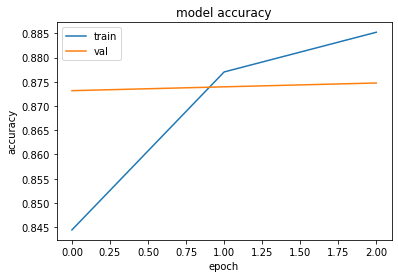

In [99]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

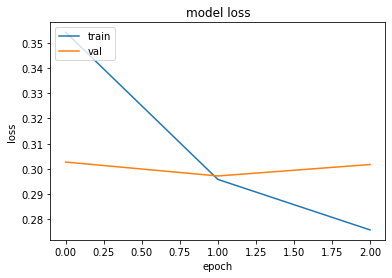

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### evaluate model

In [101]:
test_path = "./dev.csv"
raw_version = False

In [102]:
test_df = pd.read_csv(test_path, delimiter='\t' if raw_version else None  , index_col=0)
test_df['clean_comment'] = test_df['comment'].apply(TextCleaner.clean_text)
test_ids, test_mask, test_segments = tokenize(test_df.clean_comment, tokenizer, max_len)

error
error


In [103]:
y_pred = model.predict([test_ids, test_mask])

In [104]:
y_pred = np.array(y_pred > 0.5).astype("int32")

In [105]:
print(classification_report(test_df.label_id, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3150
           1       0.86      0.90      0.88      3150

    accuracy                           0.87      6300
   macro avg       0.88      0.87      0.87      6300
weighted avg       0.88      0.87      0.87      6300



In [106]:
print("precision_score", precision_score(test_df.label_id, y_pred , average="macro"))
print("recall_score", recall_score(test_df.label_id, y_pred , average="macro"))
print("f1_score", f1_score(test_df.label_id, y_pred , average="macro"))

precision_score 0.8753914728646954
recall_score 0.8747619047619049
f1_score 0.8747093736126552
